In [1]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Convolution2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D

import kapre 
from kapre.time_frequency import Spectrogram

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

import scipy
from scipy import signal
from itertools import islice
import pandas as pd

from UtilNNDL import bandpass_cnt
from UtilNNDL import exponential_running_standardize

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Using TensorFlow backend.


In [2]:
#import the data
A01T = h5py.File('/home/carla/Downloads/project_datasets/project_datasets/A01T_slice.mat','r')
data = np.copy(A01T['image'])
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

#for STFT we DO NOT swap the axes 
#data = np.swapaxes(data, 1,2)
data = data[:,:22,:]

#check the data dimensionality
print data.shape
print labels.shape

(288, 22, 1000)
(288,)


In [5]:
data_mv = data*(1e6)

In [8]:
print data_mv.shape 
data_bp = bandpass_cnt(data_mv, 4, 38, 250, filt_order=3,axis=1)

(288, 22, 1000)


In [7]:
data_standardized = np.zeros_like(data)
for i in range(data.shape[0]):
    data_standardized[i] = exponential_running_standardize(data_bp[i].T, factor_new=0.001, init_block_size=1000, eps=1e-4).T
print data_standardized.shape

(288, 22, 1000)


In [21]:
data_standardized = exponential_running_standardize(data[0].T, factor_new=0.001, init_block_size=None, eps=1e-4).T

In [22]:
np.array_equal(data_standardized_1000, data_standardized)

False

In [142]:
#Experimental, try adding 24 zeros the the end of the matrix such that the shape is the same as in the paper
buf = np.zeros([288,22,24])
print buf.shape 
print data.shape
databuf = np.concatenate([data,buf],axis=2)
print databuf.shape

(288, 22, 24)
(288, 22, 1000)
(288, 22, 1024)


In [143]:
# Check min and max values
data = np.delete(data,56,0)
labels = np.delete(labels,56,0)
print data.shape
print labels.shape

(287, 22, 1000)
(287,)


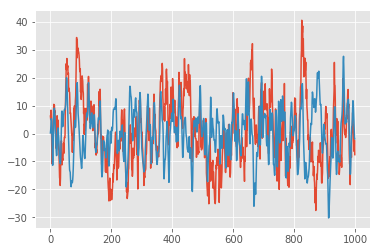

In [60]:
#Notch filter
fs = 250.0
f0 = 120.0
Q = 30.0
w0 = f0/(fs/2)
b,a = signal.iirnotch(w0, Q)

#data_f = signal.filtfilt(b,a,data[0])
data_f = signal.lfilter(b,a,data)

#plt.plot(data[0,0])
#plt.plot(data_f[0,0])

#Highpass filter
fs = 250.0
f0 =0.5
w0 = f0/(fs/2)
b, a = signal.butter(2, w0, 'highpass')
data_f = signal.lfilter(b,a,data_f)
plt.clf
#plt.plot(data[0,0])
#plt.plot(data_f[0,0])

#Bandpass filter
fs = 250.0
f0 =2
f1 =60
w0 = f0/(fs/2)
w1 = f1/(fs/2)
b, a = signal.butter(5, [w0,w1], 'bandpass')
data_f = signal.lfilter(b,a,data_f)
plt.clf
plt.plot(data[0,0])
plt.plot(data_f[0,0])

In [144]:
#Clip the input data to be within 6 stds of the mean
print np.max(data_f)
print np.min(data_f)
mean = np.mean(data_f)
std = np.std(data_f)
data_clip = np.clip(data_f, mean-(6*std), mean+(6*std))
print mean
print std
print np.max(data_clip)
print np.min(data_clip)

56.451272267
-44.2992766159
-0.00209444847932
7.69432964724
46.1638834349
-44.2992766159


In [70]:
#Finally normalize the data for each session
mean = np.mean(data_f, axis=0)

print mean.shape 

(22, 1000)


In [160]:
n=512
data_slice = np.array(zip(*[islice(data[0,0],i,None) for i in range(n)]))[::122]
print data[0,0].shape 
print data_slice.shape
label_sliced_all  = np.repeat(labels, 110)
print labels.shape
print label_sliced_all.shape

(1000,)
(5, 512)
(287,)
(31570,)


In [165]:
#incorrect version of slicing saved just incase 
data_sliced_all = np.zeros([287,110,512])
for j in range(0,data.shape[0]):
    print j
    data_sliced = []
    for e in range(0,data.shape[1]):
        data_slice = np.array(zip(*[islice(data[j,e],i,None) for i in range(n)]))[::122]
        if e == 0:
            data_sliced = data_slice
        else:
            data_sliced = np.vstack([data_sliced, data_slice])
    data_sliced_all[j] = data_sliced 
    
print data_sliced_all.shape

0
1
(2, 110, 512)


In [192]:
#interwoven slicing
windows = 10
window_size = 512
step = int(float(data.shape[2]-window_size)/float(windows-1))
print step
data_sliced = np.zeros([data.shape[0]*windows,data.shape[1],window_size])
for t in range(data.shape[0]):
    for w in range(windows):
        data_slice = data[t,:,(w*step):window_size+(w*step)]
        data_sliced[(t*windows)+w] = data_slice
               
print data_sliced.shape 
label_sliced  = np.repeat(labels, windows)
print label_sliced.shape 

54
(2870, 22, 512)
(2870,)


In [45]:
#one-hot-encode the data for use with categorical_crossentropy
labels_cata = labels - 769
print labels_cata
labels_cata = to_categorical(labels_cata, num_classes=4)
print labels_cata

[3 2 1 0 0 1 2 3 1 2 0 0 0 3 1 1 0 0 2 0 1 3 3 2 0 3 3 1 3 3 1 0 1 2 2 2 3
 2 0 3 1 2 1 2 3 1 2 0 0 0 3 1 0 2 0 2 1 3 0 2 2 0 2 1 3 3 3 2 0 3 1 3 1 0
 2 1 0 2 2 0 2 3 3 1 0 1 3 1 3 2 1 1 1 2 3 0 1 3 0 2 2 3 0 0 2 1 3 3 3 1 0
 2 1 3 0 3 2 1 3 3 0 1 1 2 3 1 0 0 3 1 0 2 1 1 2 0 3 2 2 2 2 0 1 0 1 0 0 2
 2 1 2 3 0 3 0 0 1 3 2 1 3 2 3 2 3 1 1 3 0 1 1 1 2 3 0 3 0 2 0 3 0 2 0 1 2
 2 3 0 1 3 1 2 2 0 3 1 3 0 0 2 2 1 3 1 1 0 1 3 3 1 1 1 1 3 3 2 3 0 1 2 1 0
 3 0 3 0 0 0 0 2 2 3 1 2 2 2 3 2 0 2 0 3 1 3 3 2 3 3 2 1 3 2 0 1 1 1 2 1 3
 2 3 1 2 0 3 0 2 3 0 2 0 1 1 0 3 0 3 2 2 0 2 1 1 0 2 0 1 0]
[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]
